In [1]:
import sys
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML")
sys.path.append("/home/watkinsz/Desktop/For_Zack/ML/FeH")
from fitsParser.fitsParser import fitsParser
import pandas as pd
import numpy as np
import re
from modelValidator import psMetric, cut, shuffleDwarfs, conf_matrix, plotRes, plot, norm_inputs, monte_carlo, printTable, transformer_man
from function import save_data
from sklearn.neural_network import MLPRegressor as mlp
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
fits= fitsParser(includefile = '../FeH/FeHdata.txt')
youc = fits.getAllObj()[1]
cut(fits)
cut(youc)
data = fits.data.sample(frac = 1)
data['test_flag'] = [0]*int(len(data)*0.8)+[1]*(len(data)-int(len(data)*0.8))
output = 'CaHK_0'
inputs = [x for x in fits.inputs if x!=output]
train = data[data['test_flag']==0]
numbins = 5
uncerts = train[fits.input_uncert]
start =min(train['CaHK_0'])
spread = max(train['CaHK_0'])-start
bins = [train[(train['CaHK_0']>=i*spread/numbins+start)&(train['CaHK_0']<(i+1)*spread/numbins+start)] 
        if i!= numbins-1 else train[(train['CaHK_0']>=i*spread/numbins+start)]  for i in range (numbins)]
maxsize = max([len(b) for b in bins])
trainmonte = pd.DataFrame(columns = fits.inputs)
for b in bins:
    
    if len(b)!=maxsize:
        uncert = pd.DataFrame(columns = fits.inputs)
        for key in uncert.keys():
            uncert[key] = b['d'+key]
        trainmonte = trainmonte.append(monte_carlo(b[fits.inputs], uncert, N=maxsize/len(b)), sort=True)
    else:
        trainmonte = trainmonte.append(b[fits.inputs], sort = True)
train = trainmonte

Using TensorFlow backend.



Data saved

condition on dg_fpsf cut 22 inputs
condition on dr_fpsf cut 23 inputs
condition on di_fpsf cut 6 inputs
condition on dz_fpsf cut 2 inputs
condition on dy_fpsf cut 14 inputs
condition on dCaHK_0 cut 14 inputs
condition on du_0 cut 158 inputs
condition on dFeHadop cut 280 inputs
10.66% of inputs cut

Data saved

condition on dFeHadop cut 6 inputs
1.42% of inputs cut


In [2]:
params = {
    'hidden_layer_sizes' : (64,128,64),
    'max_iter' : 300,
    'batch_size' : 600,
    'solver' : 'adam',
    'activation' : 'relu',
    'verbose' : True,
    'tol': 0
}


model = mlp(**params)
model.fit(train[inputs], train[output])

Iteration 1, loss = 9.48757165
Iteration 2, loss = 0.09997988
Iteration 3, loss = 0.05211246
Iteration 4, loss = 0.03951914
Iteration 5, loss = 0.03790468
Iteration 6, loss = 0.03716426
Iteration 7, loss = 0.03580888
Iteration 8, loss = 0.03436374
Iteration 9, loss = 0.03388617
Iteration 10, loss = 0.03354305
Iteration 11, loss = 0.03277043
Iteration 12, loss = 0.03297213
Iteration 13, loss = 0.03235368
Iteration 14, loss = 0.03279815
Iteration 15, loss = 0.03259817
Iteration 16, loss = 0.03223922
Iteration 17, loss = 0.03229026
Iteration 18, loss = 0.03221508
Iteration 19, loss = 0.03194335
Iteration 20, loss = 0.03234826
Iteration 21, loss = 0.03173359
Iteration 22, loss = 0.03182514
Iteration 23, loss = 0.03213315
Iteration 24, loss = 0.03210433
Iteration 25, loss = 0.03185810
Iteration 26, loss = 0.03190392
Iteration 27, loss = 0.03237910
Iteration 28, loss = 0.03138730
Iteration 29, loss = 0.03162948
Iteration 30, loss = 0.03173559
Iteration 31, loss = 0.03127064
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size=600, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(64, 128, 64), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0,
       validation_fraction=0.1, verbose=True, warm_start=False)

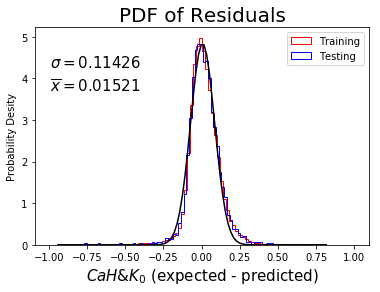

In [3]:
data['CaHK_pred'] = model.predict(data[inputs])
data['res'] = data['CaHK_pred']-data['CaHK_0']
res = [x for x in data[data['test_flag']==1]['res'] if -1<x<1]
trainRes = [x for x in data['res'] if -1<x<1]
plt.hist(trainRes, bins = 100 , histtype = 'step', color = 'red' , density = True , label = 'Training')
y, x , _ = plt.hist(res, bins=100, histtype='step', color = 'blue', density = True, label = "Testing")
plt.legend(loc = 'upper right')
for i in range(len(x)-1):
    x[i]=0.5*(x[i]+x[i+1])
    
    


g_init = models.Gaussian1D(amplitude=5., mean=0.1, stddev=0.1)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:len(x)-1], y)
plt.plot(x, g(x), 'k')

plt.annotate('$\sigma = %.5f$' % np.std(res),
            xy=(50, 225), xycoords='figure points', fontsize=15)
plt.annotate('$\overline{x} =%.5f$'%(np.mean(res)),
             xy=(50,200), xycoords = 'figure points', fontsize = 15)
plt.title('PDF of Residuals', fontsize = 20)
plt.xlabel('$CaH&K_0$ (expected - predicted)', fontsize = 15)
plt.ylabel('Probability Desity')
plt.savefig('fakeCaHKplt.png')
plt.show()

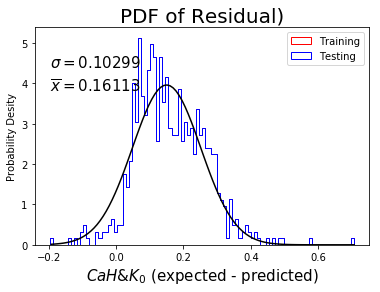

In [4]:
youc.data['CaHK_pred'] = model.predict(youc.data[inputs])
youc.data['res'] = youc.data['CaHK_pred'] - youc.data['CaHK_0']
youc.data['test_flag']=1
res = [x for x in youc.data[youc.data['test_flag']==1]['res'] if -1<x<1]
trainRes = [x for x in youc.data['res'] if -1<x<1]
plt.hist(trainRes, bins = 100 , histtype = 'step', color = 'red' , density = True , label = 'Training')
y, x , _ = plt.hist(res, bins=100, histtype='step', color = 'blue', density = True, label = "Testing")
plt.legend(loc = 'upper right')
for i in range(len(x)-1):
    x[i]=0.5*(x[i]+x[i+1])
    
    


g_init = models.Gaussian1D(amplitude=5., mean=0.1, stddev=0.1)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x[:len(x)-1], y)
plt.plot(x, g(x), 'k')

plt.annotate('$\sigma = %.5f$' % np.std(res),
            xy=(50, 225), xycoords='figure points', fontsize=15)
plt.annotate('$\overline{x} =%.5f$'%(np.mean(res)),
             xy=(50,200), xycoords = 'figure points', fontsize = 15)
plt.title('PDF of Residual)', fontsize = 20)
plt.xlabel('$CaH&K_0$ (expected - predicted)', fontsize = 15)
plt.ylabel('Probability Desity')
plt.show()

In [5]:
import joblib
def loadAll(filename):
    x  = [joblib.load(filename + end +".P") for end in ["", "Params", "Data"]]
    return x[0],x[1],x[2] #model, params, data

testmodel, testp, testd = loadAll('../FeH/SynthPhotoNN/PredlimClassVal1')
testd_fake = testd.copy(deep = True)
testd_fake['CaHK_0'] = model.predict(testd[inputs])
fakefits = fitsParser(includefile = '../FeH/FeHdata.txt')
fakefits.data = testd_fake
fakefits.makeColours(N=10)


In [6]:
def com_matrix(df, mets, classes, exp_class = 'class', pred_class = 'FeH_pred'):
    return [[len(data[data[pred_class]==c])*1.0/len(data) if len(data) != 0 else -1 for c in classes] for data in 
             [df[((mets[i]>df['FeHadop'])&(df['FeHadop']>mets[i+1]) if i!= len(mets)-1 else df['FeHadop']<mets[i-1])] for i in range(len(mets))]]

def pretty_print(matrix, rows, columns):
    display(pd.DataFrame(matrix, columns = columns, index = rows))
    
def purities(data, classes):
    return [[len(data[(data['FeH_pred']==c1)&(data['class']==c2)])*1.0/len(data[data['FeH_pred']==c1]) if len(data[data['FeH_pred']==c1])!= 0 else -1 for c2 in classes]
            for c1 in classes]

# With real CaHK

In [7]:
data = testd.copy()
classes = testp['classes']
i = [-2,-2.5,-3]
pur, com = psMetric(data, inc = i)


#data['FeH_pred'] = data['FeH_pred']*[0 if x==0 else 1 for x in data['bin_class']]
print 'all y.'
print printTable(i ,pur,com)
print pd.DataFrame(conf_matrix(data, classes), columns = classes, index = classes) , '\n'      
print 'test y'             
pur2, com2 = psMetric(data[(data['test_flag']==1)], inc = i)
print printTable(i,pur2,com2)
print pd.DataFrame(conf_matrix(data[(data['test_flag']==1)], classes), columns = classes, index = classes),'\n'  
print 'pristine'
pur3, com3 = psMetric(data, inc = i, pred = 'FeHround_prist')
print printTable(i,pur3,com3)
print pd.DataFrame(conf_matrix(data, classes, pred = 'FeHround_prist'), columns = classes, index = classes),'\n' 

all y.
| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.5243 | 0.7668      |
| -3.0    | 0.3023 | 0.2826      |

          -2.0      -2.5      -3.0
-2.0  0.563275  0.409429  0.027295
-2.5  0.251208  0.657005  0.091787
-3.0  0.152174  0.565217  0.282609 

test y
| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.4615 | 0.7660      |
| -3.0    | 0.2857 | 0.2222      |

          -2.0      -2.5      -3.0
-2.0  0.505882  0.470588  0.023529
-2.5  0.236842  0.684211  0.078947
-3.0  0.222222  0.555556  0.222222 

pristine
| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.4081 | 0.9921      |
| -3.0    | 0.1098 | 0.6304      |

          -2.0      -2.5      -3.0
-2.0  0.096774  0.531017  0.372208
-2.5  0.009662  0.579710  0.410628
-3.0  0.000000  0.369565  0.630435 



# With fake CaHK

In [8]:


pretrans = lambda data : [[1 if False not in [x[i] > y or y == x[i] for y in x ] else 0 for i in range(len(x))] for x in data] 
fakefits.data['FeH_pred'] = [testp['classes'][x.index(1)] for x in pretrans(testmodel.predict(fakefits.data[testp['colours']]))]

data = fakefits.data
classes = testp['classes']
i = [-2,-2.5,-3]
pur, com = psMetric(data, inc = i)

#data['FeH_pred'] = data['FeH_pred']*[0 if x==0 else 1 for x in data['bin_class']]
print 'all y.'
print printTable(i ,pur,com)
print pd.DataFrame(conf_matrix(data, classes), columns = classes, index = classes) , '\n'      
print 'test y'             
pur2, com2 = psMetric(data[(data['test_flag']==1)], inc = i)
print printTable(i,pur2,com2)
print pd.DataFrame(conf_matrix(data[(data['test_flag']==1)], classes), columns = classes, index = classes),'\n'  
print 'pristine'
pur3, com3 = psMetric(data, inc = i, pred = 'FeHround_prist')
print printTable(i,pur3,com3)
print pd.DataFrame(conf_matrix(data, classes, pred = 'FeHround_prist'), columns = classes, index = classes),'\n' 

all y.
| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.5714 | 0.0158      |
| -3.0    | -1.000 | 0.0000      |

          -2.0      -2.5  -3.0
-2.0  0.992556  0.007444   0.0
-2.5  0.985507  0.014493   0.0
-3.0  0.978261  0.021739   0.0 

test y
| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 1.0000 | 0.0426      |
| -3.0    | -1.000 | 0.0000      |

          -2.0      -2.5  -3.0
-2.0  1.000000  0.000000   0.0
-2.5  0.947368  0.052632   0.0
-3.0  1.000000  0.000000   0.0 

pristine
| [Fe/H]< | purity | completness |
----------------------------------
| -2.0    | 1.0000 | 1.0000      |
| -2.5    | 0.4081 | 0.9921      |
| -3.0    | 0.1098 | 0.6304      |

          -2.0      -2.5      -3.0
-2.0  0.096774  0.531017  0.372208
-2.5  0.009662  0.579710  0.410628
-3.0  0.000000  0.369565  0.630435 



In [9]:
testp.keys()

['colours', 'classes', 'binsize']